In [ ]:
import pandas as pd
import numpy as np
from pandas import read_excel
import os

from collections import Counter
import tensorflow as tf
import keras as ks
from keras.models import Sequential
from keras.layers import LSTM,Dense,Dropout,Activation,Embedding,Flatten,Bidirectional, Conv1D, MaxPooling1D
from keras.optimizers import SGD,Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import Sequence


import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import nltk
from nltk.util import ngrams
import re
from sklearn.preprocessing import LabelEncoder

In [ ]:
df = pd.read_csv('Text_Image.csv')
display(df)
df['GENRE'] = df['GENRE'].astype('category')
df.info()
df.dropna(inplace=True)
print(df.shape)
df['Image'] = df['Image'].str.strip()
df['Final'] = df['Final'].str.strip()


,Final,GENRE,Image
0,১০১০ গাণিতিক কুইজ,0.0,১০১০ গাণিতিক কুইজ.png
1,গাণিতিক সংখার মজার অংক,0.0,গাণিতিক সংখার মজার অংক.png
2,১১৮ টি মৌলের ইতিবৃত্ত,0.0,১১৮ টি মৌলের ইতিবৃত্ত.png
3,420 গণিত,0.0,420 গণিত.png
4,৫০৫ গাণিতিক কুইজ,0.0,৫০৫ গাণিতিক কুইজ.png
...,...,...,...
4201,অতীন্দ্রিয় উপন্যাস,3.0,অতীন্দ্রিয়.png
4202,রম্যরচনা সংগ্রহ,3.0,রম্যরচনা সংগ্রহ বনফুল.jpg
4203,মুখোশ একটি নদীর উপন্যাস,3.0,মুখোশ একটি নদীর নাম.jpg
4204,মা অক্সিজেন রচনা,3.0,আম্মার অক্সিজেন.jpg


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4206 entries, 0 to 4205
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype   
---  ------  --------------  -----   
 0   Final   4206 non-null   object  
 1   GENRE   4206 non-null   category
 2   Image   4206 non-null   object  
dtypes: category(1), object(2)
memory usage: 70.2+ KB
(4206, 3)


In [ ]:
def text_to_word_list(text):
    text = text.split()
    return text

def replace_strings(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           u"\u00C0-\u017F"          #latin
                           u"\u2000-\u206F"          #generalPunctuations

                           "]+", flags=re.UNICODE)
    english_pattern=re.compile('[a-zA-Z0-9]+', flags=re.I)
    #latin_pattern=re.compile('[A-Za-z\u00C0-\u00D6\u00D8-\u00f6\u00f8-\u00ff\s]*',)

    text=emoji_pattern.sub(r'', text)
    text=english_pattern.sub(r'', text)

    return text

def remove_punctuations(my_str):
    #punctuations = '''````£|¢|Ñ+-*/=EROero৳০১২৩৪৫৬৭৮৯012–34567•89।!()-[]{};:'"“\’,<>./?@#$%^&*_~‘—॥”‰🤣⚽️✌�￰৷￰'''
    punctuations = '''````£|¢|Ñ+-*/=EROero৳012–34567•89।!()-[]{};:'"“\’,<>./?@#$%^&*_~‘—॥”‰🤣⚽️✌�￰৷￰'''


    no_punct = ""
    for char in my_str:
        if char not in punctuations:
            no_punct = no_punct + char

    # display the unpunctuated string
    return no_punct



def joining(text):
    out=' '.join(text)
    return out

def preprocessing(text):
    out=remove_punctuations(replace_strings(text))
    return out

In [ ]:
df['Final'] = df.Final.apply(lambda x: preprocessing(str(x)))
display(df)

,Final,GENRE,Image
0,১০১০ গাণিতিক কুইজ,0.0,১০১০ গাণিতিক কুইজ.png
1,গাণিতিক সংখার মজার অংক,0.0,গাণিতিক সংখার মজার অংক.png
2,১১৮ টি মৌলের ইতিবৃত্ত,0.0,১১৮ টি মৌলের ইতিবৃত্ত.png
3,গণিত,0.0,420 গণিত.png
4,৫০৫ গাণিতিক কুইজ,0.0,৫০৫ গাণিতিক কুইজ.png
...,...,...,...
4201,অতীন্দ্রিয় উপন্যাস,3.0,অতীন্দ্রিয়.png
4202,রম্যরচনা সংগ্রহ,3.0,রম্যরচনা সংগ্রহ বনফুল.jpg
4203,মুখোশ একটি নদীর উপন্যাস,3.0,মুখোশ একটি নদীর নাম.jpg
4204,মা অক্সিজেন রচনা,3.0,আম্মার অক্সিজেন.jpg


In [ ]:
import BnLemma as lm
from collections import Counter

bl = lm.Lemmatizer()
lemmatized_words_counter = Counter()
transformation_counter = Counter()
custom_transformations = {
    "হিস্ট্রি" : "ইতিহাস",
    "ইতিহাসের" : "ইতিহাস",
    "অঙ্ক": "গণিত",
    "অঙ্কের": "গণিত",
    "গাণিতিক" : "গণিত",
    "অংকের" : "গণিত",
    "রাজ্যে": "রাজ্য",
    "চাচা": "চাচা",
    "কৈশোর" : "ছোট",
    "কৈশোরের" : "ছোট",
    "কৈশোরী" : "ছোট",
    "কৈশোরীর" : "ছোট",
    "কৈশোরদের" : "ছোট",
    "কৈশোর" : "ছোট",
    "শিশু" : "ছোট",
    "ছোট্ট" : "ছোট",
    "ছোটদার" : "ছোট",
    "শিশুর" : "ছোট",
    "শিশুদের" : "ছোট",
    "বালক" : "ছোট",
    "বালকের" : "ছোট",
    "বালিকা" : "ছোট",
    "বালিকার" : "ছোট",
    "ছোটদের" : "ছোট",
    "ছোট" : "ছোট",
    "কমিক্স" : "কমিকস",
    "গ্রাফিক" : "কমিকস",
    "কমিক্সের" : "কমিকস",
    "কমিকস" : "কমিকস",
    "কার্টুন" : "কমিকস",
    "কমিক্‌স" : "কমিকস",
    "গুড্ডুবুড়া": "কমিকস",
    "টিনটিন" : "কমিকস",
    "সিসিমপুরে": "কমিকস",
    "সিসিমপুর" : "কমিকস",
    "টিনটিনের" : "কমিকস",
    "টিনটিনে" : "কমিকস",
    "টমের " : "কমিকস",
    "জেরি" : "কমিকস",
    "টম" : "কমিকস",
    "ডোরেমন" : "কমিকস",
    "ডোরেমনের" : "কমিকস",
    "সিনডেরেলা": "কমিকস",
    "সিনডেরেলার" : "কমিকস",
    "বেসিক আলী" : "কমিকস",
    "নোমান" : "কমিকস",
    "বাবু" : "কমিকস",
    "গুবলে" : "কমিকস",
    "সিনডরেলা" : "কমিকস",
    "প্যারাহীন" : "কমিকস",
    "ডোরা" : "কমিকস",
    "স্পাইডারম্যান" : "কমিকস",
    "স্পাইডারম্যানের" : "কমিকস",
    "ডোরার" : "কমিকস",
    "জাদুকর" : "জাদু",
    "পশুপাখির" : "প্রাণি",
    "বাঘরা" : "প্রাণি",
    "ব্যাঙ" : "প্রাণি",
    "বাঘ" : "প্রাণি",
    "মাছের" : "প্রাণি",
    "শালিকছানা" : "পাখি",
    "হাঁস" : "পাখি",
    "পাখির" : "পাখি",
    "পাখি" : "পাখি",
    "পাখিদের": "পাখি",
    "ময়নাপাখি": "পাখি",
    "ময়না" : "পাখি",
    "শালিক" : "পাখি",
    "বুবলিদের" : "পাখি",
    "বুবলি" : "পাখি",
    "পিঁপড়ে" : "প্রাণি",
    "পায়রা" : "পাখি",
    "পায়রার" : "পাখি",
    "ফড়িং" : "পাখি",
    "ফড়িংর" : "পাখি",
    "প্রজাপতি" : "পাখি",
    "প্রজাপতির" : "পাখি",
    "টিয়া" : "পাখি",
    "ইঁদুর" : "প্রাণি",
    "বিড়াল" : "প্রাণি",
    "বিড়ালের" : "প্রাণি",
    "বিড়ালদের" : "প্রাণি",
    "বিড়ালেরা" : "প্রাণি",
    "কাঠবিড়ালির" : "প্রাণি",
    "নেকড়ে" : "প্রাণি",
    "নেকড়ের" : "প্রাণি",
    "বাদুড়ের" : "প্রাণি",
    "বাদুড়" : "প্রাণি",
    "কাঠবিড়াল" : "প্রাণি",
    "জলপরি" : "প্রাণি",
    "পরী" : "প্রাণি",
    "পরি" : "প্রাণি",
    "পরির" : "প্রাণি",
    "পরীর" : "প্রাণি",
    "ব্যাঙের" : "প্রাণি",
    "ব্যাঙ" : "প্রাণি",
    "হাতি": "প্রাণি",
    "হাতির": "প্রাণি",
    "তেলাপোকা": "প্রাণি",
    "মাছ": "প্রাণি",
    "সিংহ": "প্রাণি",
    "হনুমান" : "প্রাণি",
    "হনুমানের" : "প্রাণি",
    "বানর" : "প্রাণি",
    "বানরের" : "প্রাণি",
    "কুমিরের " : "প্রাণি",
    "কুমির" : "প্রাণি",
    "যাদুকরের" : "জাদু",
    "যাদুকর" : "জাদু",
    "প্রেম" : "ভালোবাসা",
    "প্রেমের" : "ভালোবাসা",
    "প্রেমে" : "ভালোবাসা",
    "প্রেমের" : "ভালোবাসা",
    "ভালোবাসা" : "ভালোবাসা",
    "ভালোবাসার" : "ভালোবাসা",
    "ভালোবাসায়" : "ভালোবাসা",
    "প্রিয়তমা" : "ভালোবাসা",
    "লাভিং" : "ভালোবাসা",
    "প্রিয়তমার" : "ভালোবাসা",
    "রচনাবলি" : "গল্প",
    "রচনাবলী " : "গল্প",
    "রচনাসমগ্র" : "গল্প",
    "হরর" : "ভয়",
    "ভূত" : "ভয়",
    "যকের" : "ভয়",
    "ছোটগল্প" : "গল্প",
    "কাব্য" : "কবিতা",
    "জননী" : "মা",
}

def lemmatize_sentence(sentence):
    try:
        words = sentence.split()
        lemmatized_words = []
        for word in words:
            #lemma_word = bl.lemma(word)
            if word in custom_transformations:
                #print(f"Original: {word}, Lemmatized: {custom_transformations[word]}")
                lemma_word = custom_transformations[word]
            else:
                lemma_word = bl.lemma(word)
            if word != lemma_word:
                transformation_counter[(word, lemma_word)] += 1
                lemmatized_words_counter[lemma_word] += 1
                #print(f"Original: {word}, Lemmatized: {lemma_word}")  # Print the transformation
            lemmatized_words.append(lemma_word)
        return ' '.join(lemmatized_words)
    except KeyError as e:
        print(f"KeyError: {e} for sentence: {sentence}")
        return sentence


df['Final'] = df['Final'].apply(lemmatize_sentence)


# Total number of lemmatized words
total_lemmatized_words = sum(lemmatized_words_counter.values())


print(f"Total number of lemmatized words: {total_lemmatized_words}")

top_40_lemmatized_words = lemmatized_words_counter.most_common(40)
print("\nTop 60 lemmatized words:")
for word, count in top_40_lemmatized_words:
    print(f"{word}: {count} times")



top_40_transformations = transformation_counter.most_common(40)
print("\nTop 40 transformations:")
for (original, transformed), count in top_40_transformations:
    print(f"{original} ->{transformed}: {count}")


KeyError: '' for sentence: মুক্তিযুদ্ধের বয়ানে ইসলাম
Total number of lemmatized words: 5817

Top 60 lemmatized words:
বিজ্ঞান: 144 times
কমিকস: 114 times
গণিত: 107 times
প্রাণি: 82 times
মজা: 70 times
গল্প: 70 times
বাংলাদেশ: 68 times
ভালোবাসা: 57 times
মহাবিশ্বে: 40 times
ইতিহাস: 40 times
বাংলা: 36 times
ছোট: 36 times
জীবন: 33 times
মুক্তিযুদ্ধ: 32 times
রাজনীতি: 32 times
দেশ: 31 times
ভারত: 28 times
হওয়া: 27 times
রহস্য: 26 times
সমগ্র: 26 times
বঙ্গবন্ধু: 26 times
বাঙালি: 26 times
পাখি: 25 times
জানা: 24 times
দিন: 24 times
সভ্য: 24 times
জাদু: 23 times
ভয়: 23 times
মা: 22 times
নির্বাচক: 22 times
এ: 21 times
পদার্থ: 21 times
সোনা: 21 times
ভূত: 21 times
বিশ্ব: 20 times
যাওয়া: 20 times
স্বাধীন: 20 times
হ: 19 times
করা: 18 times
হাত: 18 times

Top 40 transformations:
মজার ->মজা: 68
বিজ্ঞানের ->বিজ্ঞান: 66
গ্রাফিক ->কমিকস: 56
বাংলাদেশের ->বাংলাদেশ: 52
গণিতের ->গণিত: 51
বাংলার ->বাংলা: 31
গল্পে ->গল্প: 30
মহাবিশ্বের ->মহাবিশ্বে: 22
নির্বাচিত ->নির্বাচক: 22
গল্পসমগ্র ->সমগ্র: 21
সভ্য

In [ ]:
from collections import Counter


category_list = df.GENRE.unique().tolist()

for i in category_list:
    temp = df.loc[df['GENRE'] == i].copy()
    temp.loc[:, 'temp_list'] = temp['Final'].apply(lambda x: str(x).split())
    top = Counter([item for sublist in temp['temp_list'] for item in sublist])
    temp = pd.DataFrame(top.most_common(20))
    temp.columns = ['Common_words', 'count']
    temp.style.background_gradient(cmap='Blues')
    temp = temp.style.set_caption('Top 20 Words In ' + str(i) + " Category")
    display(temp)

,Common_words,count
0,বিজ্ঞান,225
1,গণিত,196
2,ও,143
3,মজা,69
4,মহাবিশ্বে,44
5,কথা,43
6,গল্প,43
7,পদার্থ,33
8,প্রোগ্রামিং,31
9,মহাকাশ,31


,Common_words,count
0,কমিকস,123
1,প্রাণি,76
2,ও,73
3,আর,54
4,জাদু,47
5,ছবি,46
6,গল্প,45
7,ছোট,36
8,পাখি,32
9,রহস্য,19


,Common_words,count
0,ও,193
1,ইতিহাস,163
2,বাংলাদেশ,98
3,রাজনীতি,80
4,বঙ্গবন্ধু,68
5,মুক্তিযুদ্ধ,42
6,ভারত,40
7,দ্য,39
8,বাংলা,39
9,ঢাকা,35


,Common_words,count
0,গল্প,158
1,উপন্যাস,97
2,কবিতা,80
3,ভালোবাসা,63
4,সমগ্র,50
5,ও,44
6,জীবন,22
7,নির্বাচক,21
8,শ্রেষ্ঠ,20
9,ভয়,18


In [ ]:
from collections import Counter


data1 = pd.read_excel('stopwords_bangla2.xlsx')
stop = data1['words'].tolist()


removed_stopwords_counter = Counter()


def stopwordRemoval(text):
    words = str(text).split()
    filtered_words = []
    removed_stopwords = []

    for word in words:
        if word not in stop:
            filtered_words.append(word)
        else:
            removed_stopwords.append(word)
            removed_stopwords_counter[word] += 1


    return ' '.join(filtered_words)


df['Final'] = df['Final'].apply(stopwordRemoval)

# Display the top 40 most common removed stopwords
top_40_removed_stopwords = removed_stopwords_counter.most_common(80)
print("Top 40 removed stopwords:")
for word, count in top_40_removed_stopwords:
    print(f"{word}: {count} times")



Top 40 removed stopwords:
ও: 453 times
দ্য: 83 times
আর: 71 times
থেকে: 54 times
অব: 50 times
এবং: 50 times
এ: 36 times
দিন: 36 times
প্রথম: 34 times
জানা: 32 times
জন্য: 30 times
দেখা: 29 times
তিন: 26 times
না: 24 times
যে: 24 times
শেষ: 24 times
হাত: 22 times
আমি: 22 times
বাড়ি: 22 times
উত্তর: 21 times
করা: 20 times
যাওয়া: 20 times
লাল: 20 times
হ: 19 times
একটি: 19 times
যা: 18 times
সংখ্যা: 18 times
সাত: 18 times
কেন: 18 times
চার: 18 times
নাম: 18 times
কে: 17 times
পথ: 17 times
বছর: 17 times
কি: 16 times
যত: 16 times
তারা: 16 times
আমাদের: 16 times
শত: 16 times
যখন: 16 times
হাজার: 15 times
কী: 14 times
শূন্য: 13 times
এর: 12 times
দুই: 12 times
আজ: 11 times
হায়: 11 times
ঘর: 11 times
বলা: 11 times
সব: 10 times
আপনার: 10 times
কত: 9 times
মান: 9 times
উচ্চ: 9 times
এস: 9 times
থাকা: 9 times
যায়: 9 times
পাঁচ: 9 times
কিছু: 8 times
আসা: 8 times
দেওয়া: 8 times
পারা: 8 times
তার: 8 times
অন্য: 7 times
গা: 7 times
সবার: 7 times
নেই: 7 times
সমান: 7 times
গ্রহণ: 6 times
প্রাথমিক:

In [ ]:
df['Image'] = df['Image'].apply(lambda x: os.path.join('All_Image/', x))
display(df)

,Final,GENRE,Image
0,১০১০ গণিত কুইজ,0.0,All_Image/১০১০ গাণিতিক কুইজ.png
1,গণিত সংখার মজা অংক,0.0,All_Image/গাণিতিক সংখার মজার অংক.png
2,১১৮ মৌল বৃত্ত,0.0,All_Image/১১৮ টি মৌলের ইতিবৃত্ত.png
3,গণিত,0.0,All_Image/420 গণিত.png
4,৫০৫ গণিত কুইজ,0.0,All_Image/৫০৫ গাণিতিক কুইজ.png
...,...,...,...
4201,অতীন্দ্রিয় উপন্যাস,3.0,All_Image/অতীন্দ্রিয়.png
4202,রম্য সংগ্রহ,3.0,All_Image/রম্যরচনা সংগ্রহ বনফুল.jpg
4203,মুখোশ নদী উপন্যাস,3.0,All_Image/মুখোশ একটি নদীর নাম.jpg
4204,মা অক্সিজেন রচনা,3.0,All_Image/আম্মার অক্সিজেন.jpg


In [ ]:
df = df.sample(frac=1).reset_index(drop=True)

In [ ]:
temp1 = df.groupby('GENRE').count()['Final'].reset_index().sort_values(by='Final',ascending=False)
temp1.style.background_gradient(cmap='Purples')

C:\Users\20201017\AppData\Local\Temp\ipykernel_11132\1747853096.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  temp1 = df.groupby('GENRE').count()['Final'].reset_index().sort_values(by='Final',ascending=False)


,GENRE,Final
2,2.000000,1105
1,1.000000,1071
0,0.000000,1023
3,3.000000,1007


In [ ]:
X = df.drop('GENRE', axis=1)
y = df["GENRE"]

y = pd.get_dummies(y)

In [ ]:
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=60)
X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size=0.5, random_state=60)

In [ ]:
len(X_train)

2944

In [ ]:
len(y_train)

2944

In [ ]:
len(X_test)

631

In [ ]:
len(X_val)

631

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import Sequence
from PIL import Image

class MultiModalDataGenerator(Sequence):
    def __init__(self, df, labels, tokenizer, img_size=(224, 224), batch_size=16, max_length=8,augment=False):
        self.df = df
        self.labels_df = labels
        self.tokenizer = tokenizer
        self.img_size = img_size
        self.batch_size = batch_size
        self.max_length = max_length
        self.augment = augment
        self.image_datagen = ImageDataGenerator(rotation_range=2,
                                                width_shift_range=0.01, height_shift_range=0.02,
                                                shear_range=0.0, zoom_range=0.2, horizontal_flip=True)

    def __len__(self):
        return int(np.ceil(len(self.df) / float(self.batch_size)))

    def __getitem__(self, idx):
        batch_indices = self.df.index[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_texts = []
        batch_images = []
        batch_labels = []

        for i in batch_indices:
            batch_texts.append(self.df.at[i, 'Final'])
            img = Image.open(self.df.at[i, 'Image']).convert("RGB").resize(self.img_size)
            img_array = np.array(img)
            img_array = img_array / 255.0
            if self.augment:
                img_array = self.image_datagen.random_transform(img_array)
            batch_images.append(img_array)
            batch_labels.append(self.labels_df.loc[i].values)

        sequences = self.tokenizer.texts_to_sequences(batch_texts)
        padded_sequences = pad_sequences(sequences, maxlen=self.max_length, padding='post', truncating='post')

        batch_images = np.array(batch_images)

        batch_labels = np.array(batch_labels, dtype='float32')

        return {'text_input': padded_sequences, 'image_input': batch_images}, batch_labels






In [ ]:
# import numpy as np
# import tensorflow as tf
# from tensorflow.keras.preprocessing.image import ImageDataGenerator
# from tensorflow.keras.preprocessing.text import Tokenizer
# from tensorflow.keras.preprocessing.sequence import pad_sequences
# from tensorflow.keras.utils import Sequence
# from PIL import Image
# import matplotlib.pyplot as plt

# class MultiModalDataGenerator(Sequence):
#     def __init__(self, df, labels, tokenizer, img_size=(224, 224), batch_size=16, max_length=8, shuffle=True):
#         self.df = df.reset_index(drop=True)  # Reset index for consistency
#         self.labels_df = labels.reset_index(drop=True)  # Reset index for consistency
#         self.tokenizer = tokenizer
#         self.img_size = img_size
#         self.batch_size = batch_size
#         self.max_length = max_length
#         self.shuffle = shuffle
#         self.indices = np.arange(len(self.df))  # Create array of indices
#         self.image_datagen = ImageDataGenerator(rotation_range=2,
#                                                 width_shift_range=0.01, height_shift_range=0.02,
#                                                 shear_range=0.0, zoom_range=0.2, horizontal_flip=True)
#         if self.shuffle:
#            self.on_epoch_end()

#     def __len__(self):
#         return int(np.ceil(len(self.df) / float(self.batch_size)))

#     def __getitem__(self, idx):
#         batch_indices = self.indices[idx * self.batch_size:(idx + 1) * self.batch_size]
#         batch_texts = []
#         batch_images = []
#         batch_labels = []

#         for i in batch_indices:

#             batch_texts.append(self.df.at[i, 'Final'])
#             img = Image.open(self.df.at[i, 'Image']).convert("RGB").resize(self.img_size)
#             img_array = np.array(img)
#             img_array = img_array / 255.0
#             img_array = self.image_datagen.random_transform(img_array)
#             batch_images.append(img_array)
#             batch_labels.append(self.labels_df.loc[i].values)

#         # Tokenize and pad text data
#         sequences = self.tokenizer.texts_to_sequences(batch_texts)
#         padded_sequences = pad_sequences(sequences, maxlen=self.max_length, padding='post', truncating='post')

#         # Convert images to numpy array
#         batch_images = np.array(batch_images)

#         # Convert labels to numpy array
#         batch_labels = np.array(batch_labels, dtype='float32')

#         return {'text_input': padded_sequences, 'image_input': batch_images}, batch_labels

#     def on_epoch_end(self):
#         if self.shuffle:
#             np.random.shuffle(self.indices)

In [ ]:
vocab_size = 4000
embedding_dim = 400
max_length = 8
trunc_type='post'
oov_tok = "<OOV>"

In [ ]:
tokenizer = Tokenizer(num_words=vocab_size, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train['Final'])

In [ ]:
print(tokenizer.word_index)

{'<OOV>': 1, 'গল্প': 2, 'বিজ্ঞান': 3, 'ইতিহাস': 4, 'গণিত': 5, 'কমিকস': 6, 'বাংলাদেশ': 7, 'উপন্যাস': 8, 'কবিতা': 9, 'কথা': 10, 'রাজনীতি': 11, 'প্রাণি': 12, 'সমগ্র': 13, 'বঙ্গবন্ধু': 14, 'মজা': 15, 'জীবন': 16, 'ভালোবাসা': 17, 'রহস্য': 18, 'বাংলা': 19, 'মুক্তিযুদ্ধ': 20, 'খণ্ড': 21, 'ছোট': 22, 'ঢাকা': 23, 'মহাবিশ্বে': 24, 'জাদু': 25, 'ছবি': 26, 'মা': 27, 'ভারত': 28, 'দেশ': 29, 'মানুষ': 30, 'প্রাচীন': 31, 'বাঙালি': 32, 'ভয়': 33, 'মহাকাশ': 34, '১': 35, 'আমার': 36, 'বিশ্ব': 37, 'আন্দোলন': 38, 'এক': 39, '২': 40, 'হওয়া': 41, 'মুসলিম': 42, 'প্রোগ্রামিং': 43, 'প্রশ্ন': 44, 'পাখি': 45, 'শেখ': 46, 'পৃথিবী': 47, 'পদার্থ': 48, 'মুজিব': 49, 'সভ্য': 50, 'খেলা': 51, '১ম': 52, 'মন': 53, 'আধুনিক': 54, 'অলিম্পিয়াড': 55, 'কাহিনী': 56, 'স্বাধীন': 57, 'যুদ্ধ': 58, 'আলো': 59, 'শ্রেষ্ঠ': 60, 'নির্বাচক': 61, 'ভূত': 62, 'মেঘ': 63, 'আহমেদ': 64, 'সমাধান': 65, 'একাত্তর': 66, 'স্মৃতি': 67, 'সংগ্রাম': 68, 'রচনা': 69, 'বিপ্লব': 70, 'নীল': 71, 'অন্যান্য': 72, 'আবিষ্কার': 73, 'রাষ্ট্র': 74, 'ভাবনা': 75, '৩': 76, 'জাতি

In [ ]:
X_train.head(6)

,Final,Image
3752,ধর্ম প্রসঙ্গ,All_Image/ধর্ম প্রসঙ্গে.jpg
2719,পুঁজি,All_Image/পুঁজি.jpg
41,হান্টার্স ফরচুন পার্ট,All_Image/পাহাড়কাঞ্চনপুর.jpg
1293,এক সেরা ভৌত,All_Image/একশ বছরের সেরা ভৌতিক.png
3179,বন্ধু,All_Image/তিন বন্ধু.jpg
2348,জনতার দৃষ্টি শ্রেষ্ঠ বাঙ্গালী,All_Image/হাজার জনতার দৃষ্টিতে হাজার বছরের শ্র...


In [ ]:
train_generator = MultiModalDataGenerator(X_train, y_train, tokenizer, batch_size=16, max_length=max_length,augment=True)

In [ ]:
len(train_generator)

184

In [ ]:
val_generator = MultiModalDataGenerator(X_val, y_val, tokenizer, batch_size=16, max_length=max_length)

In [ ]:
test_generator = MultiModalDataGenerator(X_test, y_test, tokenizer, batch_size=16, max_length=max_length)

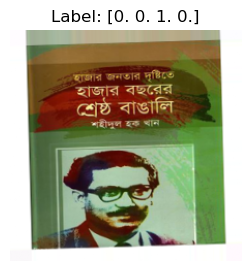

[[[1.         0.98823529 1.        ]
  [1.         0.98823529 1.        ]
  [1.         0.98823529 1.        ]
  ...
  [0.99215686 0.99215686 1.        ]
  [0.99215686 0.99215686 1.        ]
  [0.99215686 0.99215686 1.        ]]

 [[1.         0.98823529 1.        ]
  [1.         0.98823529 1.        ]
  [1.         0.98823529 1.        ]
  ...
  [0.99215686 0.99215686 1.        ]
  [0.99215686 0.99215686 1.        ]
  [0.99215686 0.99215686 1.        ]]

 [[1.         0.98823529 1.        ]
  [1.         0.98823529 1.        ]
  [1.         0.98823529 1.        ]
  ...
  [0.99215686 0.99215686 1.        ]
  [0.99215686 0.99215686 1.        ]
  [0.99215686 0.99215686 1.        ]]

 ...

 [[0.98039216 0.97254902 0.98039216]
  [0.98039216 0.97254902 0.98039216]
  [0.98039216 0.97254902 0.98039216]
  ...
  [1.         0.97647059 0.99607843]
  [1.         0.97647059 0.99607843]
  [1.         0.97647059 0.99607843]]

 [[0.98039216 0.97254902 0.98039216]
  [0.98039216 0.97254902 0.98039216]


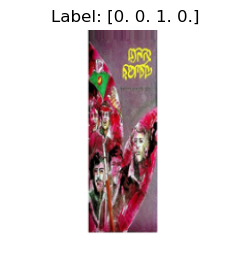

[[[1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]
  ...
  [1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]]

 [[1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]
  ...
  [1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]]

 [[1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]
  ...
  [1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]]

 ...

 [[1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]
  ...
  [1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]]

 [[1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]
  ...
  [1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]]

 [[1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]
  ...
  [1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]]]
Text: [1059   66   95  127    0    0    0    0]
Text shape: (8,)


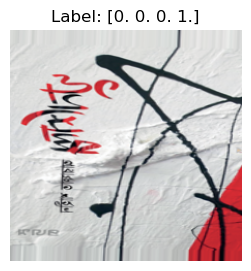

[[[0.86765303 0.8715746  0.86373146]
  [0.85482218 0.85882353 0.85090061]
  [0.85155462 0.85882353 0.84763305]
  ...
  [0.8273734  0.83129497 0.82866766]
  [0.84633847 0.85026004 0.84961979]
  [0.86267623 0.8665978  0.86269   ]]

 [[0.86709364 0.87101521 0.86317207]
  [0.85468233 0.85882353 0.85076076]
  [0.85141478 0.85882353 0.84749321]
  ...
  [0.82821249 0.83213405 0.82964659]
  [0.84703771 0.85095928 0.85017919]
  [0.8627451  0.86666667 0.8627451 ]]

 [[0.86653424 0.87045581 0.86261268]
  [0.85454248 0.85882353 0.85062091]
  [0.85127493 0.85882353 0.84735336]
  ...
  [0.82905158 0.83297314 0.83062553]
  [0.84773695 0.85165852 0.85073858]
  [0.8627451  0.86666667 0.8627451 ]]

 ...

 [[0.68761307 0.69911006 0.6954562 ]
  [0.70395083 0.71218027 0.71179397]
  [0.73757608 0.74541921 0.74541921]
  ...
  [0.74283281 0.15686275 0.19215686]
  [0.74936791 0.1570369  0.19215686]
  [0.75590302 0.16030445 0.19215686]]

 [[0.68831231 0.69966945 0.69615544]
  [0.70465007 0.71273966 0.71249321]


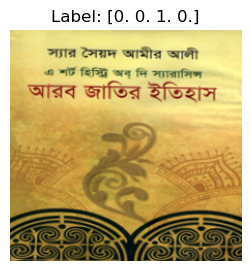

[[[0.84694313 0.80212343 0.46958301]
  [0.86185262 0.81479379 0.47753889]
  [0.86925363 0.82219481 0.48493991]
  ...
  [0.87895869 0.8325671  0.52209594]
  [0.87590958 0.82945635 0.51904683]
  [0.87274949 0.82577593 0.51588675]]

 [[0.83834862 0.79381157 0.45518618]
  [0.85929333 0.80555815 0.47720506]
  [0.87341308 0.81986282 0.49126317]
  ...
  [0.88404259 0.84050202 0.52675106]
  [0.88346921 0.84031709 0.52623933]
  [0.8830068  0.83676093 0.52583856]]

 [[0.85537496 0.80819501 0.46593829]
  [0.86541948 0.80659595 0.48096124]
  [0.87762408 0.81880055 0.49155891]
  ...
  [0.89810817 0.85153691 0.53694322]
  [0.8943438  0.85124084 0.53330214]
  [0.89080784 0.8476789  0.52983075]]

 ...

 [[0.35611198 0.31432153 0.13938742]
  [0.55041913 0.44149677 0.17132717]
  [0.71767684 0.54978948 0.22603471]
  ...
  [0.28458164 0.2330914  0.12366402]
  [0.27135446 0.23512537 0.12315225]
  [0.24523513 0.21957425 0.11438984]]

 [[0.59874842 0.46838369 0.18722919]
  [0.63296039 0.48713965 0.19655664]


In [ ]:
batch_x, batch_y = train_generator[0]

texts = batch_x['text_input']
images = batch_x['image_input']
labels = batch_y

for i in range(4,8):
    plt.figure(figsize=(6, 3))
    plt.imshow(images[i])
    plt.axis('off')
    plt.title(f"Label: {labels[i]}")

    plt.show()

    print(images[i])
    print(f"Text: {texts[i]}")
    print(f"Text shape: {texts[i].shape}")

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, LSTM, Conv2D, MaxPooling2D, Flatten, Embedding, Concatenate, Dropout,GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import VGG16
from tensorflow.keras import regularizers

In [ ]:
# def create_multimodal_model(vocab_size, max_length, img_shape, num_classes):
#     # Text input
#     text_input = Input(shape=(max_length,), name='text_input')
#     embedding = Embedding(input_dim=vocab_size, output_dim=100, input_length=max_length)(text_input)
#     lstm = LSTM(64)(embedding)

#     # Image input
#     image_input = Input(shape=img_shape, name='image_input')
#     conv1 = Conv2D(32, kernel_size=(3, 3), activation='relu')(image_input)
#     pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
#     conv2 = Conv2D(64, kernel_size=(3, 3), activation='relu')(pool1)
#     pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
#     #flatten = Flatten()(pool2)
#     pool3 = GlobalAveragePooling2D()(pool2)
#     dense = Dense(256, activation='relu')(pool3)

#     # Combine text and image features
#     concatenated = Concatenate()([lstm, dense])
#     dense1 = Dense(128, activation='relu')(concatenated)
#     dropout = Dropout(0.5)(dense1)
#     output = Dense(num_classes, activation='softmax')(dropout)

#     model = Model(inputs=[text_input, image_input], outputs=output)
#     return model

In [ ]:
def create_multimodal_model(vocab_size, max_length, img_shape, num_classes):
    # LSTM text input model
    text_input = Input(shape=(max_length,), name='text_input')
    text_model = Sequential([
        Embedding(vocab_size, 100, input_length=max_length),
        LSTM(32, return_sequences=True),
        Dropout(0.4),
        LSTM(32),
        Dense(32, kernel_regularizer=regularizers.l2(0.01), activation='relu'),
        Dropout(0.4),
    ])(text_input)

    # Pre-trained VGG16 for image input model
    base_model = VGG16(include_top=False, input_shape=img_shape)
    base_model.trainable = True


    # VGG16 image input
    image_input = Input(shape=img_shape, name='image_input')
    vgg_output = base_model(image_input)

    # Flatten VGG output for concatenation
    vgg_flatten = Flatten()(vgg_output)
    #vgg_flatten = GlobalAveragePooling2D()(vgg_output)

    # Concatenate LSTM and VGG16 outputs
    concatenated = Concatenate()([text_model, vgg_flatten])

    # Fully connected layers after concatenation
    dense1 = Dense(128, activation='relu')(concatenated)
    dropout = Dropout(0.4)(dense1)
    # dense2 = Dense(256, activation='relu')(dropout)
    # dropout2 = Dropout(0.5)(dense2)
    output = Dense(num_classes, activation='softmax')(dropout)

    # Create final model
    model = Model(inputs=[text_input, image_input], outputs=output)

    return model


In [ ]:
img_shape = (224, 224, 3)
num_classes = len(df['GENRE'].unique())
print(f"Number of classes: {num_classes}")

Number of classes: 4


In [ ]:
model = create_multimodal_model(vocab_size, max_length, img_shape, num_classes)
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 image_input (InputLayer)       [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 text_input (InputLayer)        [(None, 8)]          0           []                               
                                                                                                  
 vgg16 (Functional)             (None, 7, 7, 512)    14714688    ['image_input[0][0]']            
                                                                                                  
 sequential_3 (Sequential)      (None, 32)           426400      ['text_input[0][0]']       

In [ ]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir="New_6")
early_stopping= tf.keras.callbacks.EarlyStopping(patience= 3, restore_best_weights=True, monitor='val_loss')
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=4)

In [ ]:
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight('balanced', classes=np.unique(np.argmax(train_generator.labels_df, axis=1)), y=np.argmax(train_generator.labels_df, axis=1))
class_weights = dict(enumerate(class_weights))

print(class_weights)

{0: 1.0279329608938548, 1: 1.002724795640327, 2: 0.942381562099872, 3: 1.032258064516129}


In [ ]:
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    validation_data=val_generator,
    validation_steps=len(val_generator),
    epochs=16,
    callbacks=[early_stopping, lr_scheduler, tensorboard_callback],
    class_weight=class_weights
)

Epoch 1/16
175/184 [===========================>..] - ETA: 2s - loss: 1.5428 - accuracy: 0.4136

C:\Users\20201017\AppData\Local\anaconda3\envs\tf_env\lib\site-packages\PIL\Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


184/184 [==============================] - 70s 344ms/step - loss: 1.5330 - accuracy: 0.4181 - val_loss: 1.3395 - val_accuracy: 0.4770 - lr: 1.0000e-04
Epoch 2/16
184/184 [==============================] - 67s 362ms/step - loss: 1.3078 - accuracy: 0.5149 - val_loss: 1.2175 - val_accuracy: 0.5515 - lr: 1.0000e-04
Epoch 3/16
184/184 [==============================] - 67s 360ms/step - loss: 1.1656 - accuracy: 0.5934 - val_loss: 1.0664 - val_accuracy: 0.6070 - lr: 1.0000e-04
Epoch 4/16
184/184 [==============================] - 67s 366ms/step - loss: 0.9881 - accuracy: 0.6705 - val_loss: 0.8631 - val_accuracy: 0.7417 - lr: 1.0000e-04
Epoch 5/16
184/184 [==============================] - 67s 361ms/step - loss: 0.6855 - accuracy: 0.8077 - val_loss: 0.6466 - val_accuracy: 0.8114 - lr: 1.0000e-04
Epoch 6/16
184/184 [==============================] - 67s 364ms/step - loss: 0.5277 - accuracy: 0.8719 - val_loss: 0.6251 - val_accuracy: 0.8162 - lr: 1.0000e-04
Epoch 7/16
184/184 [===================

In [ ]:
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test accuracy: {test_accuracy}")

40/40 [==============================] - 12s 288ms/step - loss: 0.5537 - accuracy: 0.8669
Test accuracy: 0.8668779730796814


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])


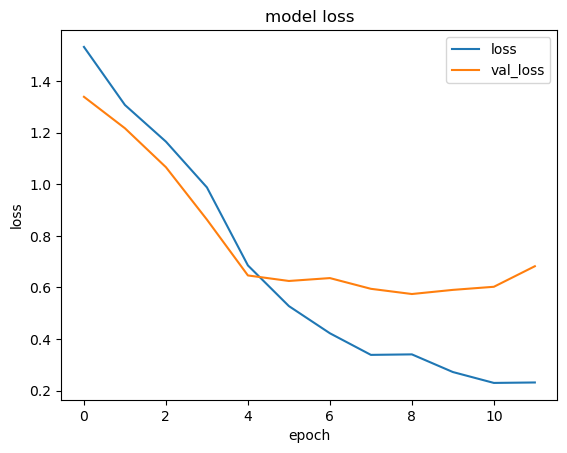

In [ ]:
print(history.history.keys())
loss = history.history['loss']
val_loss = history.history['val_loss']
plt.plot(loss)
plt.plot(val_loss)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['loss', 'val_loss'])
plt.show()

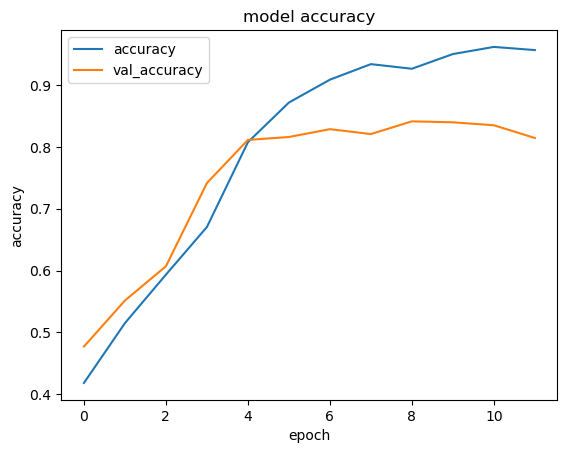

In [ ]:
accuracy = history.history['accuracy']
val_accuracy= history.history['val_accuracy']
plt.plot(accuracy)
plt.plot(val_accuracy)
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['accuracy', 'val_accuracy'])
plt.show()

In [ ]:
from sklearn.metrics import classification_report
import numpy as np

y_pred = model.predict(test_generator)
y_pred = np.argmax(y_pred, axis=1)
y_true = np.argmax(test_generator.labels_df, axis=1)
target_names = ['class 0', 'class 1', 'class 2', 'class 3']
print(classification_report(y_true, y_pred, target_names=target_names))

40/40 [==============================] - 12s 288ms/step
              precision    recall  f1-score   support

     class 0       0.89      0.87      0.88       157
     class 1       0.90      0.92      0.91       169
     class 2       0.87      0.86      0.86       156
     class 3       0.81      0.82      0.81       149

    accuracy                           0.87       631
   macro avg       0.87      0.87      0.87       631
weighted avg       0.87      0.87      0.87       631



40/40 [==============================] - 13s 315ms/step


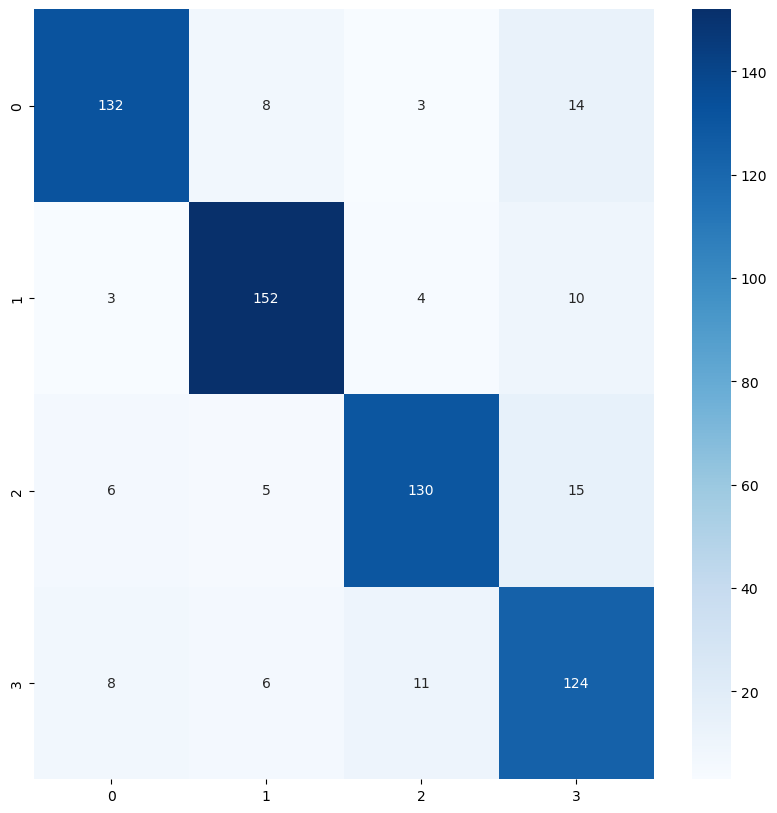

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

predictions = model.predict(test_generator)
predictions = np.argmax(predictions, axis=1)
test_labels = np.argmax(test_generator.labels_df, axis=1)
cm = confusion_matrix(test_labels, predictions)
plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues')
plt.show()

40/40 [==============================] - 12s 303ms/step


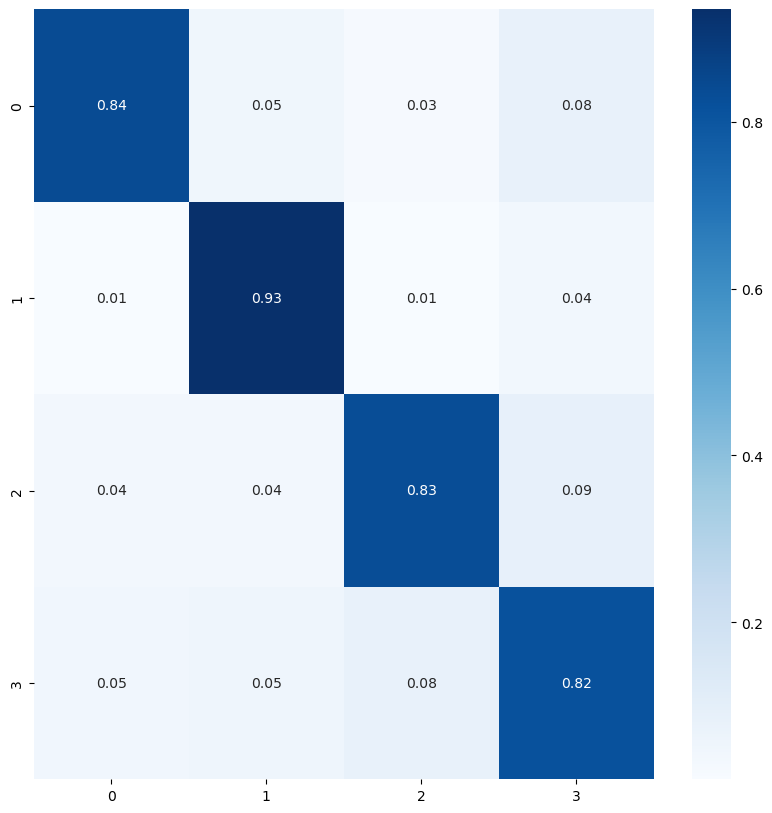

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

predictions = model.predict(test_generator)
predictions = np.argmax(predictions, axis=1)
test_labels = np.argmax(test_generator.labels_df, axis=1)

cm = confusion_matrix(test_labels, predictions, normalize='true')
plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt=".2f", cmap='Blues')
plt.show()

In [ ]:
#model.save(os.path.join('models','86_Percent.h5'))